# Julia JuMP optimisation introduction

The JuMP library provides a declarative way of defining optimisation problems which can be solved in Julia

## Import the libraries 

The JuMP library itself provides the way of defining the problem. However, you still need to pass the problem to an optimiser. Hence we give two different libraries, GLPK and IpOpt.

In [1]:
using JuMP
using GLPK
using Ipopt
using Plots

## Define Model

In this section, we will first define a model and associate the optimiser we will use to solve the problem. I'm glossing over this a little bit, but the optimiser should be chosen to fit the problem. That is, it's not necessarily trivial to select the right model and this shoudl be thought about beforehand.

Then we will define the variables we use are optimising, the constraints and the objective function.
    
We will define a simple linear programming problem as an introduction.

Minimise $$4x + y$$
Subject to
$$3x + y \ge 10$$
$$x + y \ge 5$$
$$x \ge 3, y \ge 0$$

In [2]:
model = Model(GLPK.Optimizer)

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: GLPK

In [3]:
fieldnames(Model)

(:moi_backend, :shapes, :bridge_types, :optimize_hook, :nlp_data, :obj_dict, :operator_counter, :ext)

In [4]:
@variable(model, x >= 3)
@variable(model, y >= 0)

y

In [5]:
@objective(model, Min, 4x + y)

4 x + y

In [6]:
@constraint(model, c1, 3x + y >= 10)
@constraint(model, c2, x + y >= 5)

c2 : x + y ≥ 5.0

In [7]:
print(model)

Min 4 x + y
Subject to
 c1 : 3 x + y ≥ 10.0
 c2 : x + y ≥ 5.0
 x ≥ 3.0
 y ≥ 0.0


Then to run optimise the model we simply call the optimize (note the z!) command. This will find the optimal point.

In [8]:
optimize!(model)

After running the optimisation, we can investigate whether a solution was found. If, so we find the optimal values of the variables and the objective function

In [9]:
@show termination_status(model)
@show primal_status(model)
@show value(x)
@show value(y)

termination_status(model) = MathOptInterface.OPTIMAL
primal_status(model) = MathOptInterface.FEASIBLE_POINT
value(x) = 3.0
value(y) = 2.0


2.0

In [10]:
@show objective_value(model)

objective_value(model) = 14.0


14.0

We can also access the dual solution to this problem by investigating the dual_status function. If you're familiar with dual solutions the can return the shadow values of the constraints, i.e. the variables of the dual program

In [11]:
@show dual_status(model)
@show shadow_price(c1)
@show shadow_price(c2)

dual_status(model) = MathOptInterface.FEASIBLE_POINT
shadow_price(c1) = -0.0
shadow_price(c2) = -1.0


-1.0

In [12]:
@show dual(c1)
@show dual(c2)

dual(c1) = 0.0
dual(c2) = 1.0


1.0

For completeness we'll plot the feasible region

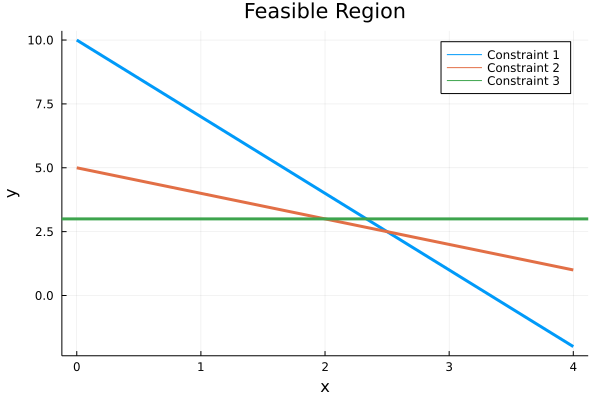

In [13]:
x_v = LinRange(0,4,100)
y_v = LinRange(0,4,100)
plot([x_v], [-3*x_v .+ 10], title = "Feasible Region", label = "Constraint 1", lw = 3)
plot!([x_v], [-x_v .+ 5], label = "Constraint 2", lw = 3)
hline!([3], label = "Constraint 3", lw = 3)
#plot!([x_v], [-4*x_v .+ 14], label = "Solution", lw = 3, linestyle=:dash)
xlabel!("x")
ylabel!("y")


## Knapsack Problem

Here we define a further constrained linear program where the variables, $$x_i$$ are binary integers, a mixed-integer program. In this case we have a list of items, their "utlity", $$u_i$$ and a constraint on the total weight, $$w_i$$ that we can carry. This is meant to be for planning purposes, and these techniques can be applied to a wide range of problems

Maximise $$\sum_{i=1}^n u_i x_i$$
Subject to 
$$\sum_{i=1}^n w_i x_i \le C$$
$$x_i \in \{0,1\}$$

In [14]:
utility = [5,3,2,7,4]
weight = [2,8,4,2,5]
capacity = 10

10

In [15]:
model = Model(GLPK.Optimizer)

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: GLPK

In this case I am declaring an array of variables, and then trying to optimise against these. Note the "Bin" at the end signifying that we are constraining this to be a binary valued variable

In [16]:
@variable(model, x[1:5], Bin)

5-element Array{VariableRef,1}:
 x[1]
 x[2]
 x[3]
 x[4]
 x[5]

In [17]:
@objective(model, Max, utility' * x)

5 x[1] + 3 x[2] + 2 x[3] + 7 x[4] + 4 x[5]

In [18]:
@constraint(model, weight' * x <= capacity)

2 x[1] + 8 x[2] + 4 x[3] + 2 x[4] + 5 x[5] ≤ 10.0

In [19]:
print(model)

Max 5 x[1] + 3 x[2] + 2 x[3] + 7 x[4] + 4 x[5]
Subject to
 2 x[1] + 8 x[2] + 4 x[3] + 2 x[4] + 5 x[5] ≤ 10.0
 x[1] binary
 x[2] binary
 x[3] binary
 x[4] binary
 x[5] binary


In [20]:
optimize!(model)

In [21]:
@show termination_status(model)
@show primal_status(model)
@show value.(x)

termination_status(model) = MathOptInterface.OPTIMAL
primal_status(model) = MathOptInterface.FEASIBLE_POINT
value.(x) = [1.0, 0.0, 0.0, 1.0, 1.0]


5-element Array{Float64,1}:
 1.0
 0.0
 0.0
 1.0
 1.0

In [31]:
if termination_status(model) == "OPTIMAL"
    print("Success")
end

## Non-linear Optimisation

We illlustrate the use of the Ipopt package as an optimiser for non-linear programming. This uses the interior point method to optimise the program,

Minimise $$x_1x_2 + x_2x_3$$
Subject to
$$x_1^2 - x_2^2 + x_3^2 \le 2$$
$$x_1^2 + x_2^2 + x_3^2 \le 10$$

In [32]:
model = Model(Ipopt.Optimizer)

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Ipopt

In [33]:
@variable(model, x[1:3])

3-element Array{VariableRef,1}:
 x[1]
 x[2]
 x[3]

In [34]:
@NLobjective(model, Min, x[1]x[2] + x[2]x[3])

In [35]:
@NLconstraint(model, x[1]^2 - x[2]^2+ x[3]^2 <= 2)
@NLconstraint(model, x[1]^2 + x[2]^2 + x[3]^2 <= 10)

(x[1] ^ 2.0 + x[2] ^ 2.0 + x[3] ^ 2.0) - 10.0 ≤ 0

In [36]:
print(model)

Min x[1] * x[2] + x[2] * x[3]
Subject to
 ((x[1] ^ 2.0 - x[2] ^ 2.0) + x[3] ^ 2.0) - 2.0 ≤ 0
 (x[1] ^ 2.0 + x[2] ^ 2.0 + x[3] ^ 2.0) - 10.0 ≤ 0


In [37]:
optimize!(model)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:       11

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equal

In [38]:
@show termination_status(model)
@show primal_status(model)
@show value.(x)

termination_status(model) = MathOptInterface.LOCALLY_SOLVED
primal_status(model) = MathOptInterface.FEASIBLE_POINT
value.(x) = [0.0, 0.0, 0.0]


3-element Array{Float64,1}:
 0.0
 0.0
 0.0